# Offline pipeline for data generation

## Import libraries

In [5]:
import cv2
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import glob

In [6]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '../')  # This adds the parent directory to the path

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Extract frames from video sequences

In [4]:
from src.frames_extractor import FrameExtractor

frame_extractor = FrameExtractor(
    directories = {
    'images_dir': '../Datasets/OakGait16/frames/', #Don't forget to add the Dataset folder to gitignore
    'clips_dir': '/mnt/c/Users/chris/Documents/OAKGait16/clips/', #Where the clips are saved in your computer
    'frs_dir': 'rgb/',
    },
    views = ['060', '075', '090', '105', '120'],
    subjects = ['000','001','002','003','004','005','006','007','008','009','010','011','012','013','014','015','016'],
    nclips = {'nm':5, 'bg':5, 'cl':5},
    verbose=True
    )

frame_extractor.extract_frames()

PROCESSING VIEW: 060
Processing subject: 000 view: 060
Processing subject: 001 view: 060
Processing subject: 002 view: 060
Processing subject: 003 view: 060
Processing subject: 004 view: 060
Processing subject: 005 view: 060
Processing subject: 006 view: 060
Processing subject: 007 view: 060
Processing subject: 008 view: 060
Processing subject: 009 view: 060
Processing subject: 010 view: 060
Processing subject: 011 view: 060
Processing subject: 012 view: 060
Processing subject: 013 view: 060
Processing subject: 014 view: 060
Processing subject: 015 view: 060
Processing subject: 016 view: 060
PROCESSING VIEW: 075
Processing subject: 000 view: 075
Processing subject: 001 view: 075
Processing subject: 002 view: 075
Processing subject: 003 view: 075
Processing subject: 004 view: 075
Processing subject: 005 view: 075
Processing subject: 006 view: 075
Processing subject: 007 view: 075
Processing subject: 008 view: 075
Processing subject: 009 view: 075
Processing subject: 010 view: 075
Proces

SHOWING VIEW: 060
Showing subject: 013


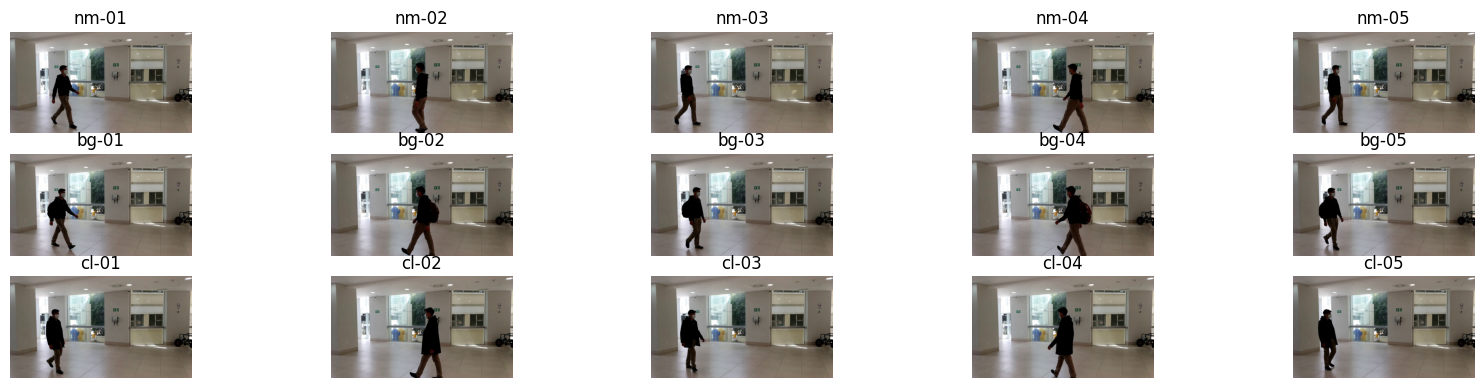

SHOWING VIEW: 075
Showing subject: 004


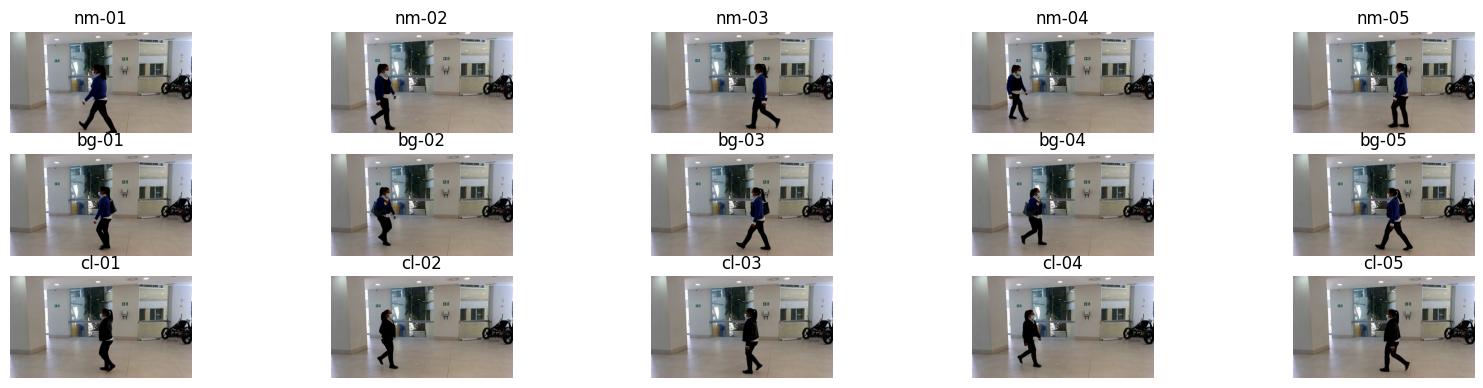

SHOWING VIEW: 090
Showing subject: 014


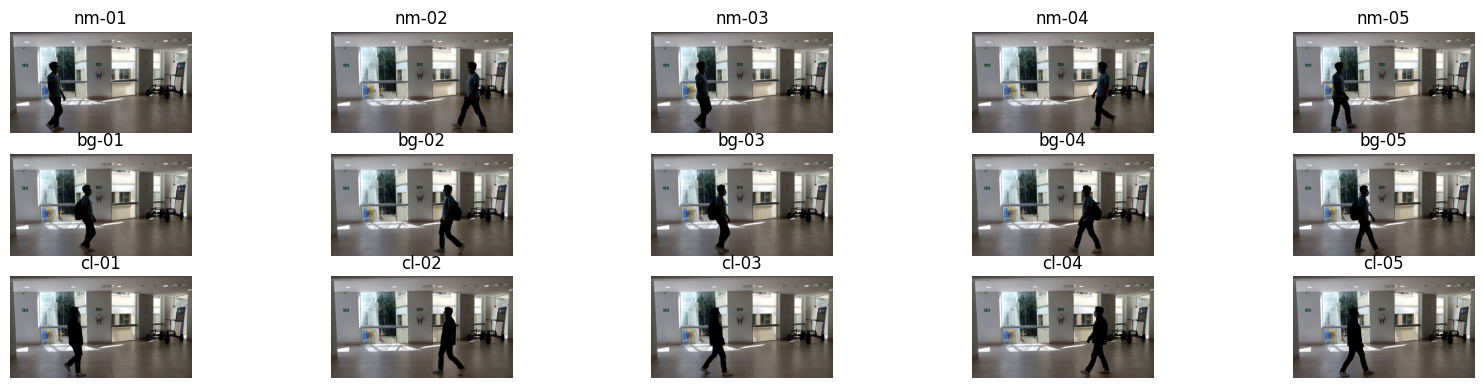

SHOWING VIEW: 105
Showing subject: 011


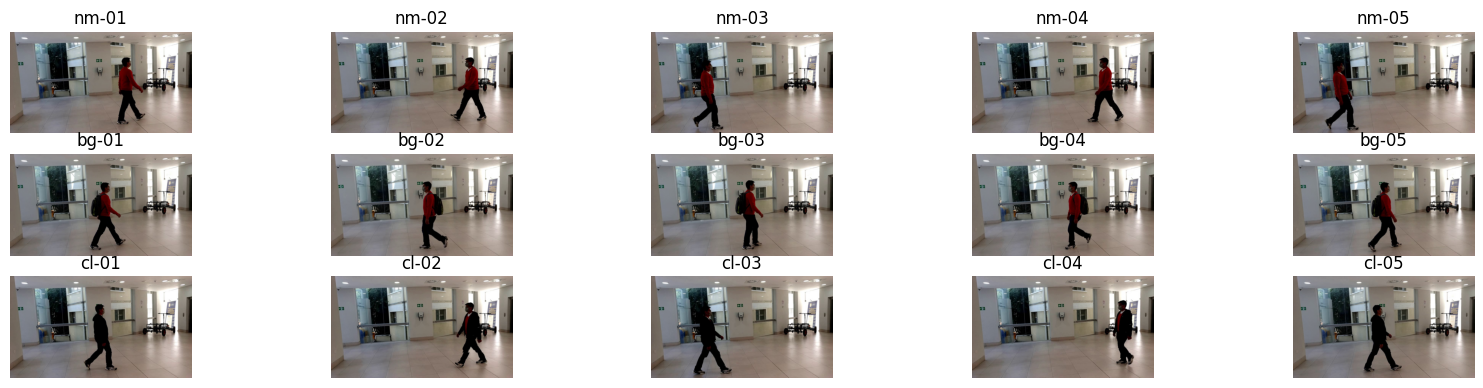

SHOWING VIEW: 120
Showing subject: 006


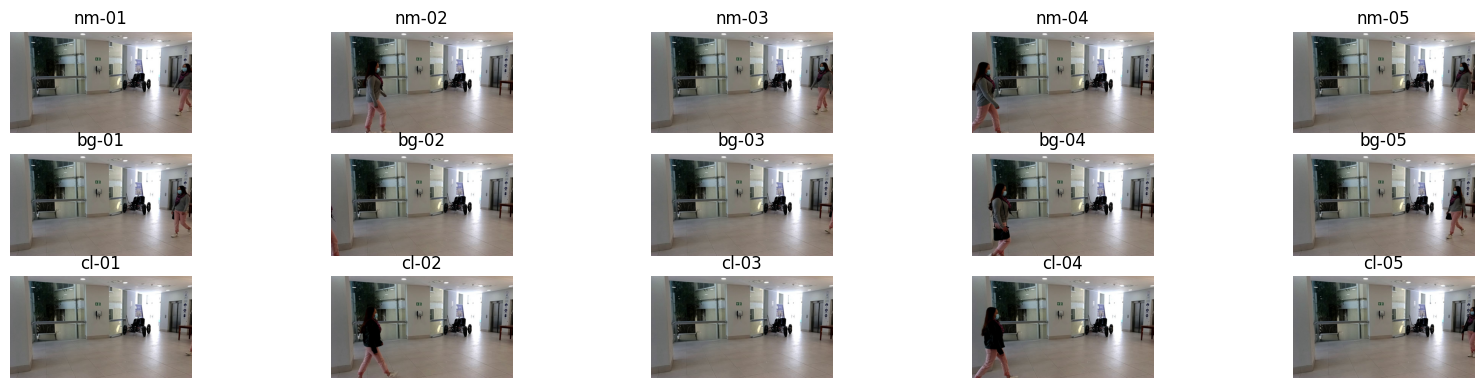

In [9]:
from src.show_images import show_images

show_images(images_dir='../Datasets/OakGait16/frames/', frs_dir = 'rgb/', views =  ['060', '075', '090', '105', '120'], num_subjects=1)

## Generate test dataset

In [3]:
from src.test_data_generator import TestDataGenerator

test_data_generator = TestDataGenerator(
    clips_directory = '/mnt/c/Users/chris/Documents/OAKGait16/clips/',
    test_clips_directory = '../Datasets/OakGait16/test_clips/',
    subjects = ['000','001','002','003','004','005','006','007','008','009','010','011','012','013','014','015','016'],
    nclips = {'nm':8, 'bg':8, 'cl':8},
    views = ['060', '075', '090', '105', '120'],
    verbose = True
)

test_data_generator.generate_test_data()

PROCESSING VIEW: 060
Processing subject: 000 view: 060
Processing subject: 001 view: 060
Processing subject: 002 view: 060
Processing subject: 003 view: 060
Processing subject: 004 view: 060
Processing subject: 005 view: 060
Processing subject: 006 view: 060
Processing subject: 007 view: 060
Processing subject: 008 view: 060
Processing subject: 009 view: 060
Processing subject: 010 view: 060
Processing subject: 011 view: 060
Processing subject: 012 view: 060
Processing subject: 013 view: 060
Processing subject: 014 view: 060
Processing subject: 015 view: 060
Processing subject: 016 view: 060
PROCESSING VIEW: 075
Processing subject: 000 view: 075
Processing subject: 001 view: 075
Processing subject: 002 view: 075
Processing subject: 003 view: 075
Processing subject: 004 view: 075
Processing subject: 005 view: 075
Processing subject: 006 view: 075
Processing subject: 007 view: 075
Processing subject: 008 view: 075
Processing subject: 009 view: 075
Processing subject: 010 view: 075
Proces

## Detection: region-of-interest extraction

For this section, the object detection model [mobileNet-ssd](https://docs.openvino.ai/latest/omz_models_model_mobilenet_ssd.html) from OpenVINO distribution was employed. It is worth mentioning that for this stage there was no retraining process, as the pre-trained model was used directly.

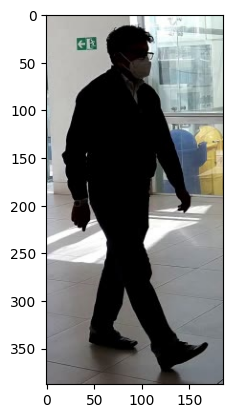

In [44]:
from src.roi_finder import ROIFinder
import matplotlib.pyplot as plt

roi_finder = ROIFinder(model_path="../../models/public/mobilenet-ssd/FP32/mobilenet-ssd.xml", device="CPU")

rgb = cv2.imread('../Datasets/OakGait16/frames/060/rgb/000/nm/nm-03/0048.jpg')
x, y, w, h = roi_finder.find_roi(rgb)
roi = cv2.cvtColor(rgb[y:h, x:w], cv2.COLOR_BGR2RGB)

plt.imshow(roi)
plt.show()

In [41]:
from src.roi_extractor import ROIExtractor

roi_extractor = ROIExtractor(
        images_dir = '../Datasets/OakGait16/frames/',
        region_of_interest_dir = '../Datasets/OakGait16/rois/',
        frs_dir = 'rgb/',
        views = ['060', '075', '090', '105', '120'], 
        subjects = ['000','001','002','003','004','005','006','007','008','009','010','011','012','013','014','015','016'],
        roi_finder = roi_finder,
        verbose = False,
        walk_types = ['nm', 'bg', 'cl'],
    )

roi_extractor.extract_roi_from_frames()

SHOWING VIEW: 060
Showing subject: 008


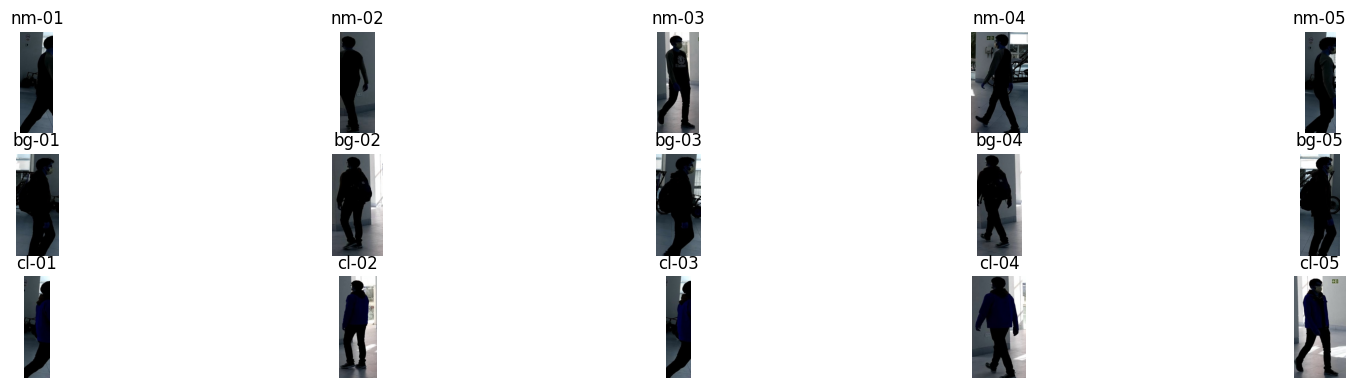

SHOWING VIEW: 075
Showing subject: 016


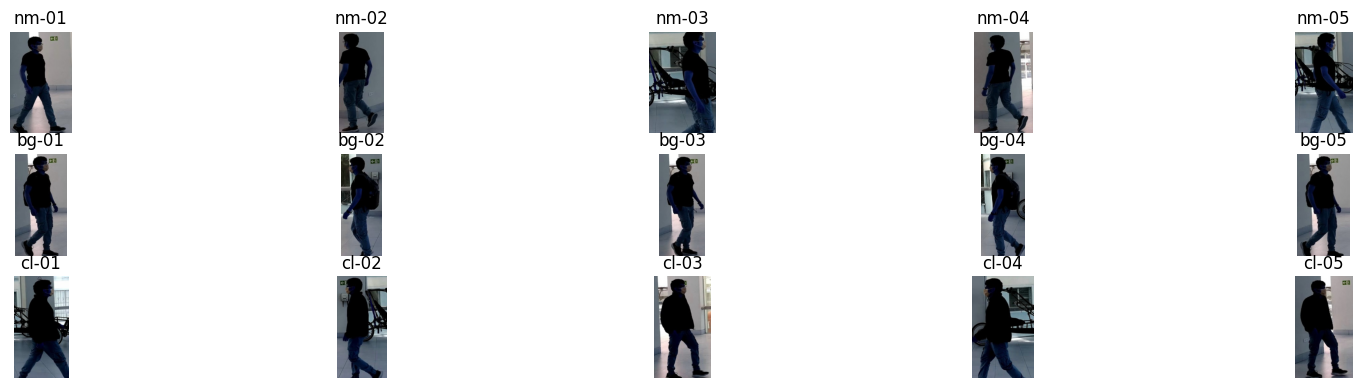

SHOWING VIEW: 090
Showing subject: 009


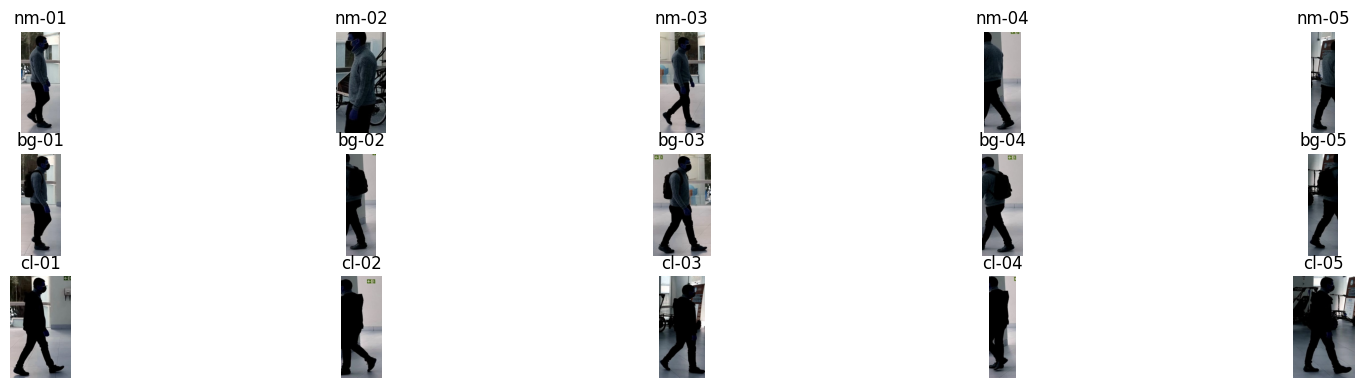

SHOWING VIEW: 105
Showing subject: 015


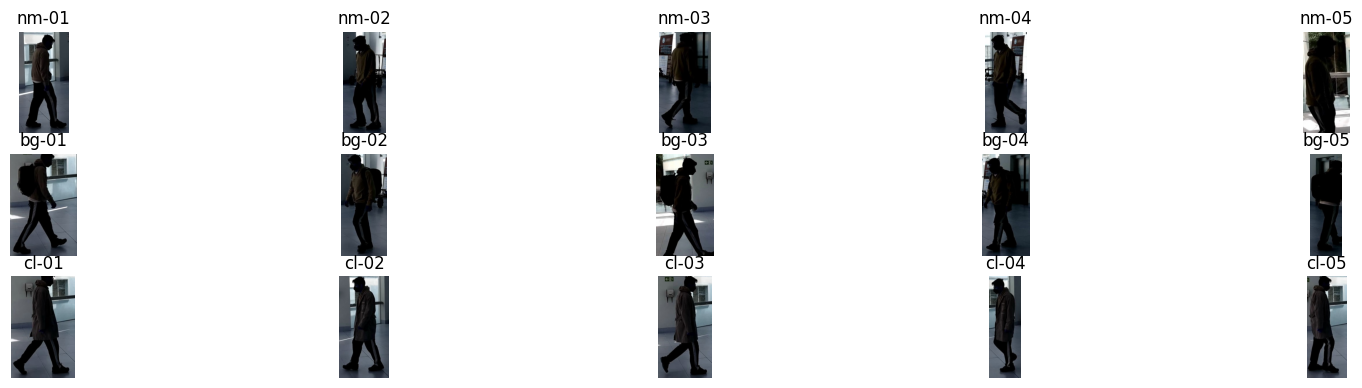

SHOWING VIEW: 120
Showing subject: 004


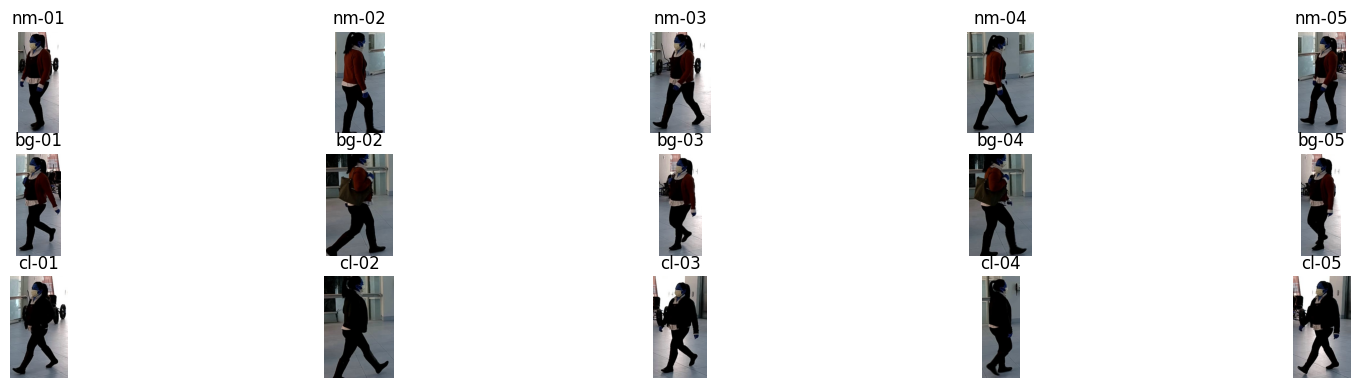

In [10]:
show_images(images_dir='../Datasets/OakGait16/rois/', views =  ['060', '075', '090', '105', '120'], num_subjects=1)

## Segmentation: semantic segmentation for obtaining binary silhouettes

(384, 149)


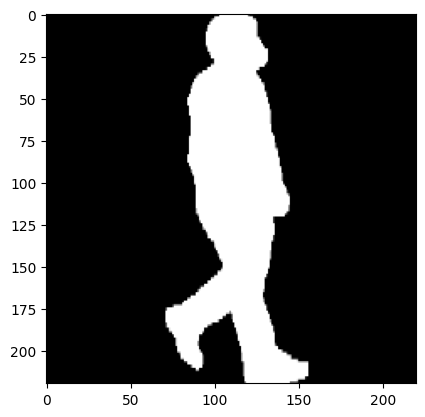

In [57]:
from src.silhouette_segmenter import SilhouetteSegmenter

segmenter = SilhouetteSegmenter(
    model_path="../../models/128x128_acc_0.8786_loss_0.1018_val-acc_0.8875_val-loss_0.0817_0.22M_13-09-22-TF_OAKGait16.xml", 
    device="CPU"
    )

# Test the silhouette segmenter
roi = cv2.imread("../Datasets/OakGait16/rois/090/000/nm/nm-03/000-nm-03-23.jpg") 
roi_height = roi.shape[0]
roi_width = roi.shape[1]
roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
sil = cv2.resize(segmenter.sil_segmentation(roi), (roi_width,roi_height)) 
plt.imshow(sil, cmap='gray')
if sil.mean() > 2:
    x, y, w, h = cv2.boundingRect(sil)
    seg_roi = sil[y:y+h,x:x+w]
    print(seg_roi.shape)
    sil_centered = segmenter.sil_centering(sil, 220)
    plt.imshow(sil_centered, cmap='gray')

In [58]:
from src.silhouette_extractor import SilhouetteExtractor

silhouette_extractor = SilhouetteExtractor(
    region_of_interest_dir = '../Datasets/OakGait16/rois/',
    silhouettes_dir = '../Datasets/OakGait16/segmented_silhouettes/',
    views = ['060', '075', '090', '105', '120'], 
    segmenter = segmenter,
    walks = ['nm', 'bg', 'cl'],
    verbose = False
    )

silhouette_extractor.extract_silhouettes_from_rois()

SHOWING VIEW: 060
Showing subject: 015


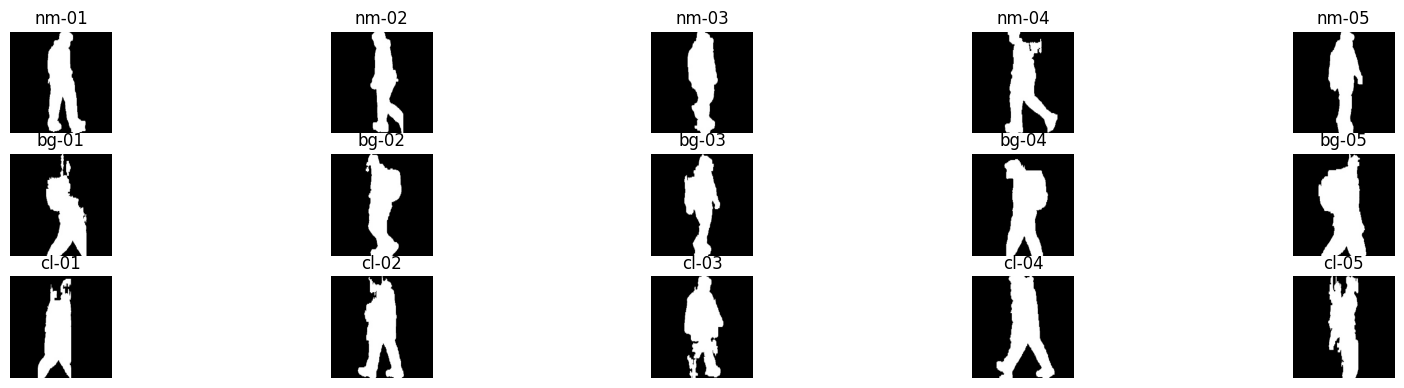

SHOWING VIEW: 075
Showing subject: 016


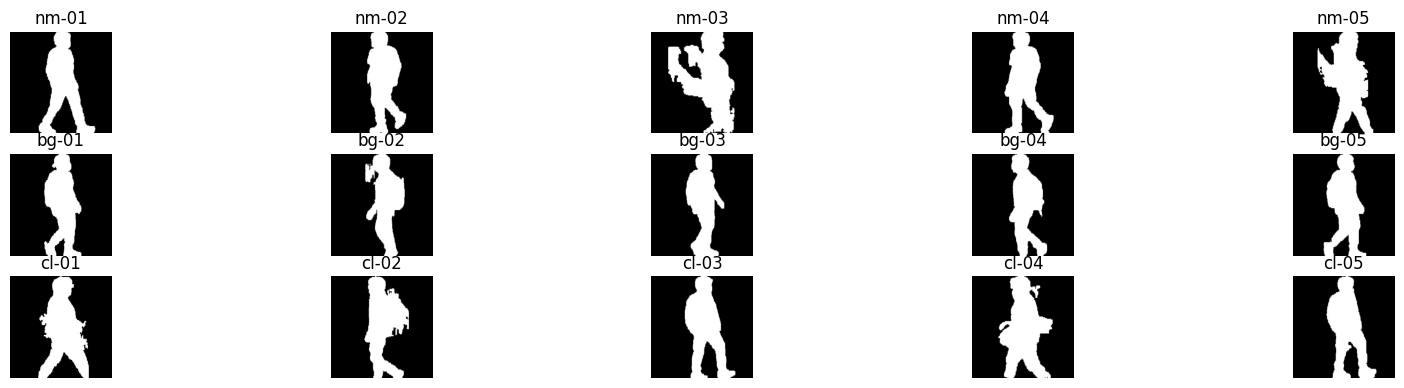

SHOWING VIEW: 090
Showing subject: 016


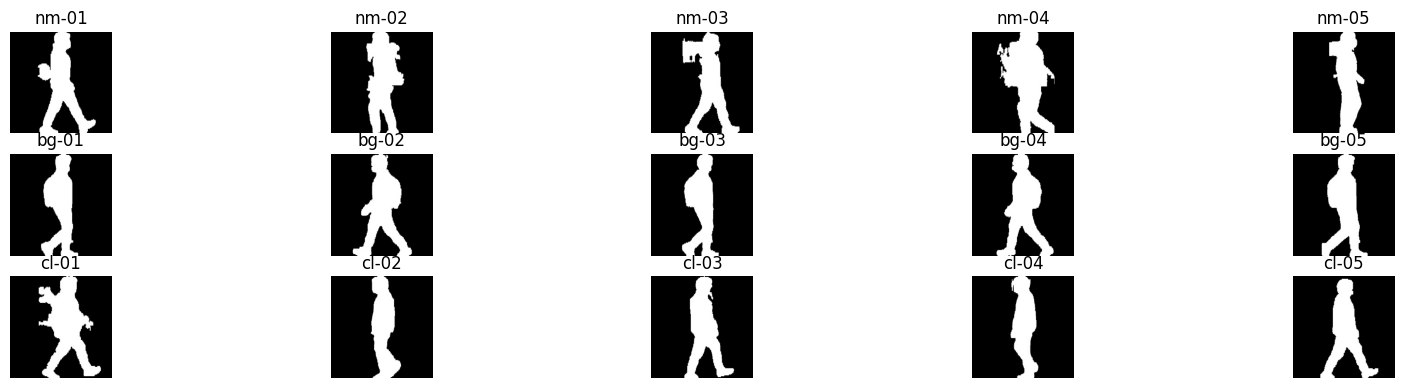

SHOWING VIEW: 105
Showing subject: 000


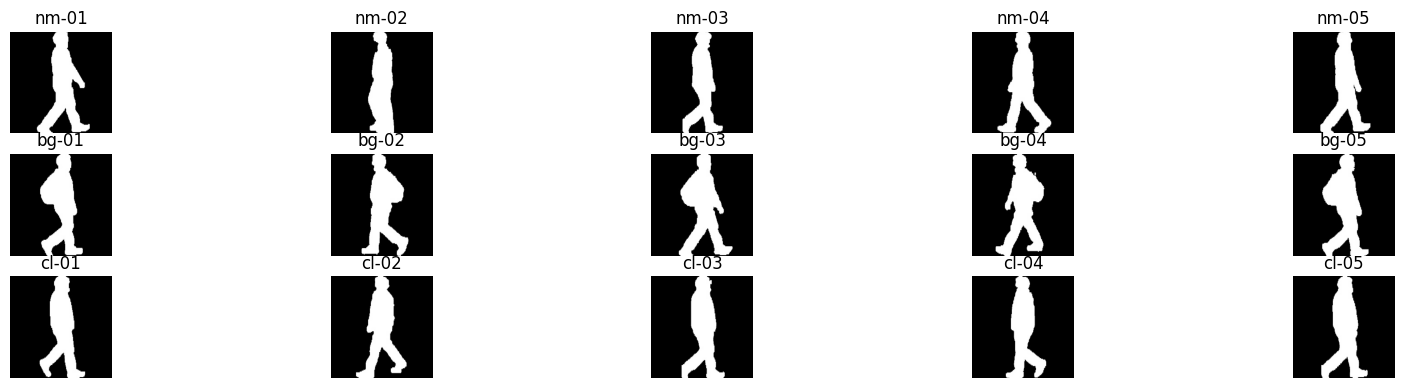

SHOWING VIEW: 120
Showing subject: 014


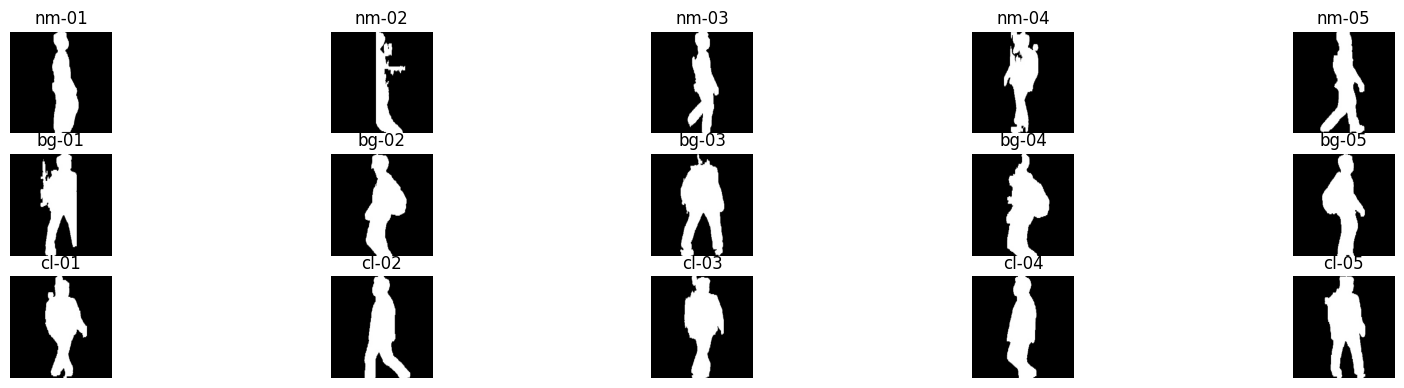

In [11]:
show_images(images_dir='../Datasets/OakGait16/segmented_silhouettes/', views =  ['060', '075', '090', '105', '120'], num_subjects=1)

## Gait representation: GEI generation

In [61]:
from src.gei_generator import GEIGenerator

gei_generator = GEIGenerator(
    silhouettes_dir = '../Datasets/OakGait16/segmented_silhouettes/',
    representations_dir = '../Datasets/OakGait16/gei_representations/',
    views = ['060', '075', '090', '105', '120'],
    walks = ['nm', 'bg', 'cl'],
    verbose = False
    )

gei_generator.extract_gei_from_silhouettes()

SHOWING VIEW: 060
Showing subject: 009


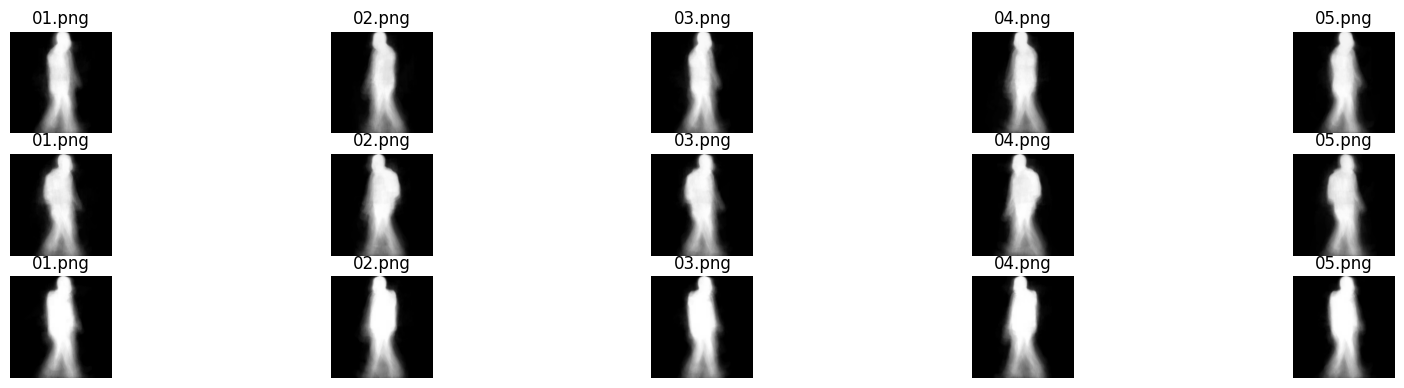

SHOWING VIEW: 075
Showing subject: 005


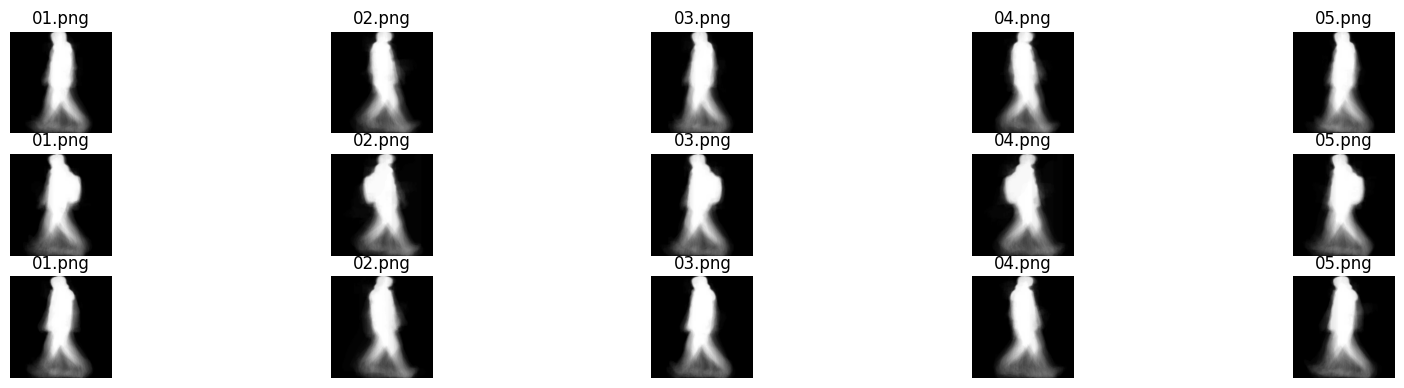

SHOWING VIEW: 090
Showing subject: 007


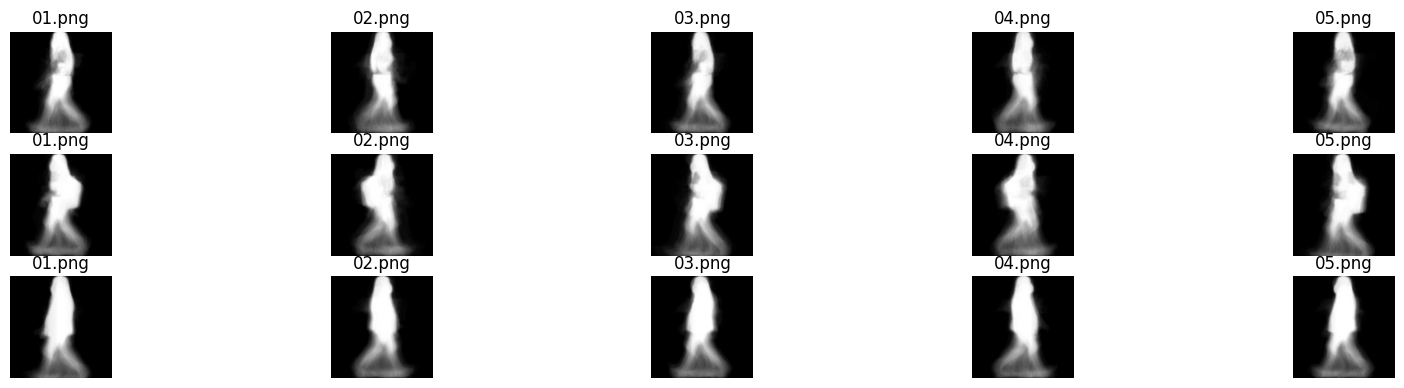

SHOWING VIEW: 105
Showing subject: 001


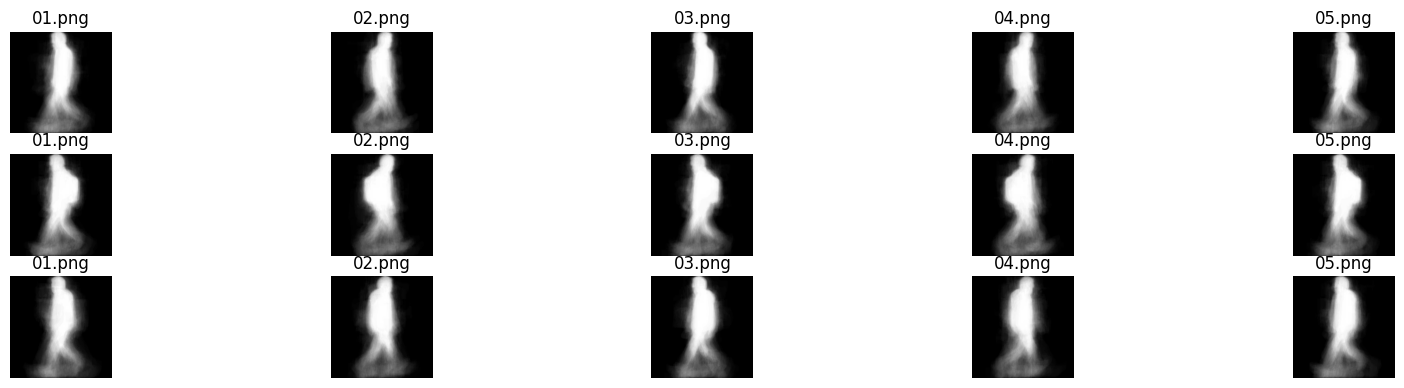

SHOWING VIEW: 120
Showing subject: 001


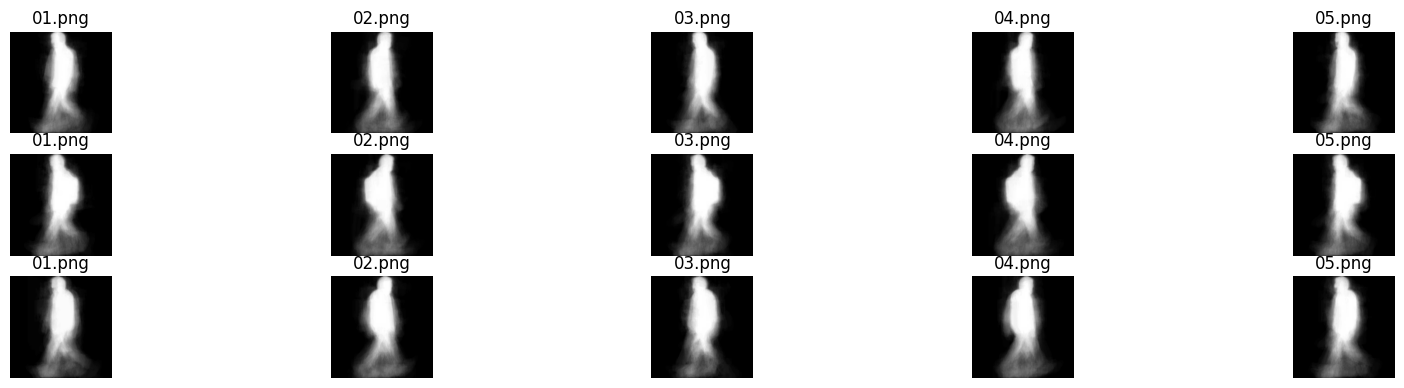

In [12]:
from src.show_representations import show_representations
show_representations('../Datasets/OakGait16/gei_representations/', ['060', '075', '090', '105', '120'], num_subjects=1)

## Classification dataset generation

In [26]:
from src.dataset_builder import DatasetBuilder

builder = DatasetBuilder(
    representations_dir='../Datasets/OakGait16/gei_representations', 
    training_path='../Datasets/OakGait16/training_datasets', 
    views=['060', '075', '090', '105', '120'],
    )
builder.build_datasets()

Processing subject: 000 view: 060 walk:nm
Processing subject: 000 view: 060 walk:bg
Processing subject: 000 view: 060 walk:cl
Processing subject: 001 view: 060 walk:nm
Processing subject: 001 view: 060 walk:bg
Processing subject: 001 view: 060 walk:cl
Processing subject: 002 view: 060 walk:nm
Processing subject: 002 view: 060 walk:bg
Processing subject: 002 view: 060 walk:cl
Processing subject: 003 view: 060 walk:nm
Processing subject: 003 view: 060 walk:bg
Processing subject: 003 view: 060 walk:cl
Processing subject: 004 view: 060 walk:nm
Processing subject: 004 view: 060 walk:bg
Processing subject: 004 view: 060 walk:cl
Processing subject: 005 view: 060 walk:nm
Processing subject: 005 view: 060 walk:bg
Processing subject: 005 view: 060 walk:cl
Processing subject: 006 view: 060 walk:nm
Processing subject: 006 view: 060 walk:bg
Processing subject: 006 view: 060 walk:cl
Processing subject: 007 view: 060 walk:nm
Processing subject: 007 view: 060 walk:bg
Processing subject: 007 view: 060 